## Statsmodel Forecast AB Testing

A/B Testing is one method of models against each other.  This demonstration will show how to use the Wallaroo pipeline step `add_random_split` and `replace_with_random_split` to randomly submit inference input data into control and challenger models.

## Prerequisites

* A Wallaroo instance version 2023.2.1 or greater.

## References

* [Wallaroo SDK Essentials Guide: Model Uploads and Registrations: Python Models](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-model-uploads/wallaroo-sdk-model-upload-python/)
* [Wallaroo SDK Essentials Guide: Pipeline Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline/)
* [Wallaroo SDK Essentials: Inference Guide: Parallel Inferences](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-inferences/#parallel-inferences)

## A/B Testing

A/B testing is a method that provides the ability to test out ML models for performance, accuracy or other useful benchmarks.  A/B testing is contrasted with the Wallaroo Shadow Deployment feature.  In both cases, two sets of models are added to a pipeline step:

* Control or Champion model:  The model currently used for inferences.
* Challenger model(s): One or more models that are to be compared to the champion model.

The two feature are different in this way:

| Feature | Description |
|---|---|
| A/B Testing | A subset of inferences are submitted to either the champion ML model or a challenger ML model. |
| Shadow Deploy | All inferences are submitted to the champion model and one or more challenger models. |

Wallaroo implements A/B testing via a pipeline step as either `wallaroo.pipeline.add_random_split` to set a new pipeline step or `wallaroo.pipeline.replace_with_random_split` to replace an existing step.

## Tutorial Steps

### Import Libraries

The first step is to import the libraries that we will need.

In [25]:
import json
import os
import datetime

import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework

# used to display dataframe information without truncating
from IPython.display import display
import pandas as pd
import numpy as np

from resources import simdb
from resources import util

pd.set_option('display.max_colwidth', None)

In [26]:
display(wallaroo.__version__)

'2023.2.1'

### Connect to the Wallaroo Instance

The first step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

In [27]:
# Login through local Wallaroo instance

wl = wallaroo.Client()

wallarooPrefix = "doc-test."
wallarooSuffix = "wallaroocommunity.ninja"

wl = wallaroo.Client(api_endpoint=f"https://{wallarooPrefix}api.{wallarooSuffix}", 
                    auth_endpoint=f"https://{wallarooPrefix}keycloak.{wallarooSuffix}", 
                    auth_type="sso")

### Set Configurations

The following will set the workspace, model name, and pipeline that will be used for this example.  If the workspace or pipeline already exist, then they will assigned for use in this example.  If they do not exist, they will be created based on the names listed below.

Workspace names must be unique.  To allow this tutorial to run in the same Wallaroo instance for multiple users, set the `suffix` variable or share the workspace with other users.

#### Set Configurations References

* [Wallaroo SDK Essentials Guide: Workspace Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-workspace/)
* [Wallaroo SDK Essentials Guide: Pipeline Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline/)

In [28]:
# used for unique connection names

suffix='john'

workspace_name = f'forecast-model-workshop{suffix}'

pipeline_name = 'forecast-workshop-pipeline'

### Set the Workspace, Pipeline and Models

The workspace will be either used or created if it does not exist, along with the pipeline.

The models were uploaded in the Upload and Deploy notebook.

In [35]:
def get_workspace(name):
    workspace = None
    for ws in wl.list_workspaces():
        if ws.name() == name:
            workspace= ws
    if(workspace == None):
        workspace = wl.create_workspace(name)
    return workspace

def get_pipeline(name):
    try:
        pipeline = wl.pipelines_by_name(name)[0]
    except EntityNotFoundError:
        pipeline = wl.build_pipeline(name)
    return pipeline

# Get the most recent version of a model in the workspace
# Assumes that the most recent version is the first in the list of versions.
# wl.get_current_workspace().models() returns a list of models in the current workspace

def get_model(mname):
    modellist = wl.get_current_workspace().models()
    model = [m.versions()[-1] for m in modellist if m.name() == mname]
    if len(model) <= 0:
        raise KeyError(f"model {mname} not found in this workspace")
    return model[0]

workspace = get_workspace(workspace_name)

wl.set_current_workspace(workspace)

pipeline = get_pipeline(pipeline_name)

# upload three models:  the control and two challengers

control_model_name = 'forecast-control-model'
challenger01_model_name = 'forecast-challenger01-model'
challenger02_model_name = 'forecast-challenger02-model'

# upload the models

bike_day_model = get_model(control_model_name)

challenger_model_01 = get_model(challenger01_model_name)

challenger_model_02 = get_model(challenger02_model_name)


### Deploy the Pipeline

We will now add the uploaded model as a step for the pipeline, then deploy it.  The pipeline configuration will allow for multiple replicas of the pipeline to be deployed and spooled up in the cluster.  Each pipeline replica will use 0.25 cpu and 512 Gi RAM.

In [37]:
# Set the deployment to allow for additional engines to run
# Undeploy and clear the pipeline in case it was used in other demonstrations
pipeline.undeploy()
pipeline.clear()
deploy_config = (wallaroo.DeploymentConfigBuilder()
                        .replica_count(1)
                        .replica_autoscale_min_max(minimum=2, maximum=5)
                        .cpus(0.25)
                        .memory("512Mi")
                        .build()
                    )

pipeline.add_model_step(bike_day_model)
pipeline.deploy(deployment_config = deploy_config)

name,forecast-workshop-pipeline
created,2023-08-02 15:50:59.480547+00:00
last_updated,2023-08-02 18:42:42.919014+00:00
deployed,True
tags,
versions,"dcaec327-1358-42a7-88de-931602a42a72, debc509f-9481-464b-af7f-5c3138a9cdb4, b0d167aa-cc98-440a-8e85-1ae3f089745a, d9e69c40-c83b-48af-b6b9-caafcb85f08b, 186ffdd2-3a8f-40cc-8362-13cc20bd2f46, 535e6030-ebe5-4c79-b5cd-69b161637a99, c5c0218a-800b-4235-8767-64d18208e68a, 4559d934-33b0-4872-a788-4ef27f554482, 94d3e20b-add7-491c-aedd-4eb094a8aebf, ab4e58bf-3b75-4bf6-b6b3-f703fe61e7af, 3773f5c5-e4c5-4e46-a839-6945af15ca13, 3abf03dd-8eab-4a8d-8432-aa85a30c0eda, 5ec5e8dc-7492-498b-9652-b3733e4c87f7, 1d89287b-4eff-47ec-a7bb-8cedaac1f33f"
steps,forecast-control-model


### Run Inference

Run a test inference to verify the pipeline is operational from the sample test data stored in `./data/testdata_dict.json`.

In [38]:
inferencedata = pd.read_json("./data/testdata_standard.df.json")
display(inferencedata)

results = pipeline.infer(inferencedata)

display(results)

,count
0,"[1526, 1550, 1708, 1005, 1623, 1712, 1530, 1605, 1538, 1746, 1472, 1589, 1913, 1815, 2115, 2475, 2927, 1635, 1812, 1107, 1450, 1917, 1807, 1461, 1969, 2402, 1446, 1851]"


,time,in.count,out.forecast,out.weekly_average,check_failures
0,2023-08-02 18:43:14.396,"[1526, 1550, 1708, 1005, 1623, 1712, 1530, 1605, 1538, 1746, 1472, 1589, 1913, 1815, 2115, 2475, 2927, 1635, 1812, 1107, 1450, 1917, 1807, 1461, 1969, 2402, 1446, 1851]","[1764, 1749, 1743, 1741, 1740, 1740, 1740]",[1745.2857142857142],0


### Create Assay



#### Build Baseline

Get some of that cv data into separate dataframe rows, run an inference.

In [39]:
def mk_dt_range_query(*, tablename: str, seed_day: str) -> str:
    assert isinstance(tablename, str)
    assert isinstance(seed_day, str)
    query = f"select count from {tablename} where date > DATE(DATE('{seed_day}'), '-1 month') AND date <= DATE('{seed_day}')"
    return query

conn = simdb.get_db_connection()

# create a set of queries, one week apart
# start with 2011-02-01 to 2011-12-31







# create the query
# query = mk_dt_range_query(tablename=simdb.tablename, seed_day='2011-03-01')
# print(query)

# # read in the data
# training_frame = pd.read_sql_query(query, conn)
# training_frame

# inference_frame = pd.DataFrame({'count': [training_frame['count'].values.tolist()]})

# display(inference_frame)

In [40]:
# create a set of queries, one week apart
# start with 2011-02-01 to 2011-12-31

from datetime import date, timedelta

current_sample_date = date(2011, 2, 1)
print(current_sample_date.strftime('%Y-%m-%d'))

# current_sample_date = None

# create our dataframe

# inference_batch_input = pd.DataFrame(columns=['date', 'count'])
# inference_batch_input = pd.DataFrame(columns=['count'])
inference_batch_input = []

while current_sample_date.strftime('%Y-%m-%d') != '2012-01-01':
    query = mk_dt_range_query(tablename=simdb.tablename, seed_day=current_sample_date.strftime('%Y-%m-%d'))
    current_sample_date = current_sample_date + timedelta(days=1)
    training_frame = pd.read_sql_query(query, conn)
    # inference_batch_input = inference_batch_input.append({'date': current_sample_date.strftime('%Y-%m-%d'), 
    #                                                         'count': training_frame['count'].values.tolist()},
    #                                                         ignore_index=True
    #                                                     )
    inference_batch_input.append(pd.DataFrame({'count': [training_frame['count'].values.tolist()]}))
    # inference_frame = pd.DataFrame({'count': [training_frame['count'].values.tolist()]})
    # print(query)
    # display(inference_frame)

display(inference_batch_input[0])

2011-02-01


,count
0,"[801, 1349, 1562, 1600, 1606, 1510, 959, 822, 1321, 1263, 1162, 1406, 1421, 1248, 1204, 1000, 683, 1650, 1927, 1543, 981, 986, 1416, 1985, 506, 431, 1167, 1098, 1096, 1501, 1360]"


In [41]:
import datetime
import time
baseline_start = datetime.datetime.now()

parallel_results = await pipeline.parallel_infer(tensor_list=inference_batch_input, timeout=20, num_parallel=16, retries=2)

display(parallel_results[0:5])
time.sleep(30)
baseline_end = datetime.datetime.now()

[                     time  \
 0 2023-08-02 18:43:21.687   
 
                                                                                                                                                                              in.count  \
 0  [801, 1349, 1562, 1600, 1606, 1510, 959, 822, 1321, 1263, 1162, 1406, 1421, 1248, 1204, 1000, 683, 1650, 1927, 1543, 981, 986, 1416, 1985, 506, 431, 1167, 1098, 1096, 1501, 1360]   
 
                                  out.forecast    out.weekly_average  \
 0  [1205, 1248, 1241, 1242, 1242, 1242, 1242]  [1237.4285714285713]   
 
    check_failures  
 0               0  ,
                      time  \
 0 2023-08-02 18:43:21.641   
 
                                                                                                                                                                               in.count  \
 0  [1349, 1562, 1600, 1606, 1510, 959, 822, 1321, 1263, 1162, 1406, 1421, 1248, 1204, 1000, 683, 1650, 1927, 1543, 981, 986, 

In [42]:
assay_name = f"forecast assay {suffix}"
assay_builder = wl.build_assay(assay_name, 
                               pipeline, 
                               control_model_name, 
                               baseline_start, 
                               baseline_end).add_iopath("output weekly_average 0")

In [43]:
baseline_run = assay_builder.build().interactive_baseline_run()

Show the baseline

In [44]:
baseline_run.baseline_stats()

,Baseline
count,334
min,1232.428571
max,5038.142857
mean,3580.337896
median,4077.785714
std,1092.960486
start,2023-08-02T18:43:20.872547Z
end,2023-08-02T18:45:22.472273Z


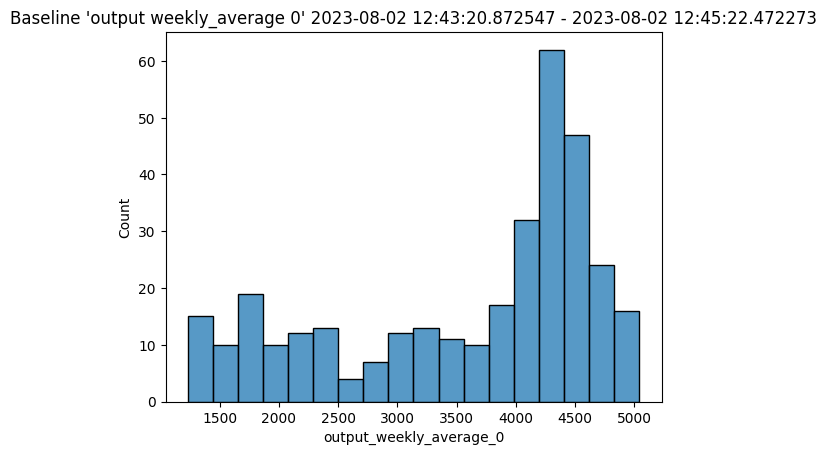

In [45]:
assay_builder.baseline_histogram()

In [ ]:
# pipeline.undeploy()

name,forecast-workshop-pipeline
created,2023-08-02 15:50:59.480547+00:00
last_updated,2023-08-02 16:26:42.554024+00:00
deployed,False
tags,
versions,"ab4e58bf-3b75-4bf6-b6b3-f703fe61e7af, 3773f5c5-e4c5-4e46-a839-6945af15ca13, 3abf03dd-8eab-4a8d-8432-aa85a30c0eda, 5ec5e8dc-7492-498b-9652-b3733e4c87f7, 1d89287b-4eff-47ec-a7bb-8cedaac1f33f"
steps,forecast-control-model
